# Fruits vs. Vegetables


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#CNN-Model" data-toc-modified-id="CNN-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>CNN Model</a></span></li><li><span><a href="#Prediction" data-toc-modified-id="Prediction-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Prediction</a></span></li></ul></div>

## Goal

The goal of this project is to build __fruits and vegetable__'s classification model by using convolutional neural network (CNN). 


## Data

fruits-360 dataset <strong data-cite="Muresan & Oltean2018">(Muresan & Oltean, 2018)</strong> published in Kaggle has 90,483 images of fruits and vegetable including 131 categories. It has training set (67,692 images) and test set (22,688 images), and I only used training data set when training a model. All image sizes are 100 x 100 pixels. 
I used the lastest version of the data (published 05/18/2020). 




**Reference** 

Horea Muresan, & Mihai Oltean (2018). Fruit recognition from images using deep learning, Acta Univ. Sapientiae, Informatica,  __10(1)__ _pp. 26-42_.



## CNN Model

In [1]:
from fastai.vision.all import *

In [2]:
import os 
os.getcwd()

'/home/ubuntu/projects'

In [3]:
f_path = Path('/home/ubuntu')
d_path = Path('/home/ubuntu/Data/')

In [4]:
d_path.ls()

(#2) [Path('/home/ubuntu/Data/.ipynb_checkpoints'),Path('/home/ubuntu/Data/fruits-360')]

In [ ]:
#!unzip -q -n {f_path}/fruits.zip -d {d_path}

In [5]:
path = Path('/home/ubuntu/Data/fruits-360/')
path.ls()

(#6) [Path('/home/ubuntu/Data/fruits-360/papers'),Path('/home/ubuntu/Data/fruits-360/Test'),Path('/home/ubuntu/Data/fruits-360/test-multiple_fruits'),Path('/home/ubuntu/Data/fruits-360/LICENSE'),Path('/home/ubuntu/Data/fruits-360/readme.md'),Path('/home/ubuntu/Data/fruits-360/Training')]

In [6]:
Path.BASE_PATH = path
path.ls()

(#6) [Path('papers'),Path('Test'),Path('test-multiple_fruits'),Path('LICENSE'),Path('readme.md'),Path('Training')]

In [7]:
t_path = Path('/home/ubuntu/Data/fruits-360/Training')
t_path.ls()

(#131) [Path('Training/Nectarine'),Path('Training/Apple Golden 2'),Path('Training/Papaya'),Path('Training/Cucumber Ripe'),Path('Training/Melon Piel de Sapo'),Path('Training/Mangostan'),Path('Training/Grape White 2'),Path('Training/Kaki'),Path('Training/Pear'),Path('Training/Tomato 2')...]

In [8]:
img = get_image_files(t_path)

Created images from training data. 

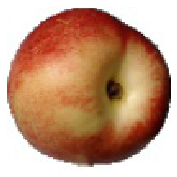

In [9]:
fn = PILImage.create(img[0])
fn.show()

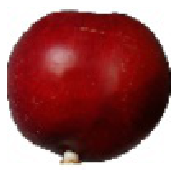

In [10]:
fn1 = PILImage.create(img[1])
fn1.show()

In [11]:
fruits = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = parent_label,
    splitter = RandomSplitter(seed=42),
    item_tfms = Resize(460),
    batch_tfms = aug_transforms(size=224, min_scale=0.75)
)

This is model summary

In [12]:
fruits.summary(t_path)

Setting-up type transforms pipelines
Found 67692 items
2 datasets of sizes 54154,13538
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/ubuntu/Data/fruits-360/Training/Potato Sweet/r2_30_100.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=100x100
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/ubuntu/Data/fruits-360/Training/Potato Sweet/r2_30_100.jpg
    applying parent_label gives
      Potato Sweet
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(109)

Final sample: (PILImage mode=RGB size=100x100, TensorCategory(109))


Setting up after_item: Pipeline: Resize -- {'size': (460, 460), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up bef

In [13]:
dls = fruits.dataloaders(t_path, bs=64)

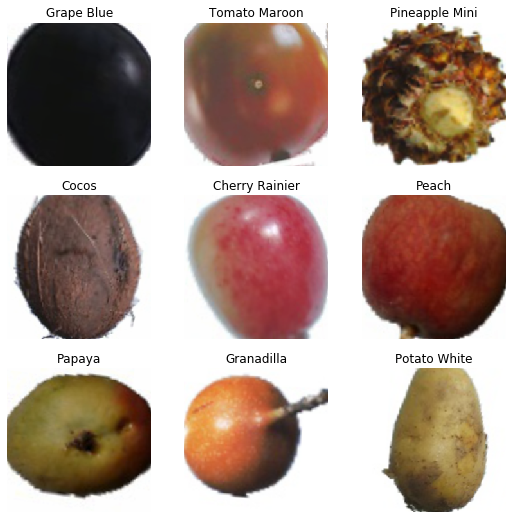

In [14]:
dls.show_batch()

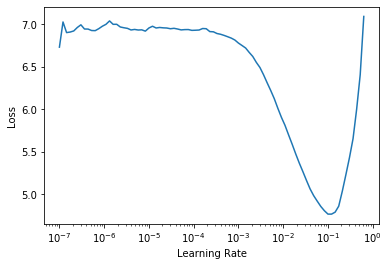

In [15]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min, lr_steep = learn.lr_find()

In order to choose appropriate learning rate, fastai creates the learning rate graph. 

In [16]:
print(f'Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}')

Minimum/10: 1.20e-02, steepest point: 1.58e-02


In [17]:
lr = 1e-2

In [ ]:
#learn.fit_one_cycle(5, base_lr=lr)

`learn.fine_tune()` performs to freeze earliest layers of model and to unfreeze late layers of model. 

In [18]:
learn.fine_tune(3, base_lr=lr)

epoch,train_loss,valid_loss,error_rate,time
0,0.247698,0.064311,0.016324,01:50


epoch,train_loss,valid_loss,error_rate,time
0,0.195075,0.067519,0.019427,02:12
1,0.034405,0.005057,0.001551,02:11
2,0.004738,0.001534,0.000074,02:10


The model shows 99% accuracy. This model is pretty doing well. We need to explore if the model predicts fruits and vegetables when we use test data set.  

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=5)

[]

In [20]:
learn.save('fruits-rn50')

Path('models/fruits-rn50.pth')

## Prediction

In [21]:
test_path = Path('/home/ubuntu/Data/fruits-360/Test')
test_path.ls()

(#131) [Path('Test/Nectarine'),Path('Test/Apple Golden 2'),Path('Test/Papaya'),Path('Test/Cucumber Ripe'),Path('Test/Melon Piel de Sapo'),Path('Test/Mangostan'),Path('Test/Grape White 2'),Path('Test/Kaki'),Path('Test/Pear'),Path('Test/Tomato 2')...]

In [22]:
test_items = get_image_files(test_path)

In [24]:
dl = learn.dls.test_dl(test_items, rm_type_tfms=1, bs=64)

In [27]:
preds, _ = learn.get_preds(dl=dl)

In [28]:
preds.shape

torch.Size([22688, 131])

In [29]:
thresh = 0.5
labelled_preds = [' '.join([learn.dls.vocab[i] for i,p in enumerate(pred) if p>thresh]) for pred in preds.numpy()]

In [30]:
labelled_preds[:5]

['Strawberry', 'Nectarine', 'Nectarine', 'Nectarine', 'Nectarine']

In [31]:
y_test = list(map(lambda x: x.parents[0].name, test_items))

In [32]:
results = pd.DataFrame({'target': y_test, 'pred': labelled_preds})

In [33]:
accuracy = results[results.target==results.pred].shape[0] / results.shape[0]

In [34]:
accuracy

0.9944464033850494

The CNN model predicted fruits and vegetable with 99% accuracy!!